### Name: Riya Shyam Huddar (MDS202431) 
### Portfolio Optimization Assignment 2

In [1]:
import os
import pandas as pd
import numpy as np
import cvxpy as cp
from scipy import sparse
import clarabel
import matplotlib.pyplot as plt
import time

### Data Cleansing and Consolidation

The NIFTY 50 dataset is provided as individual CSV files, with each file corresponding to a single stock.  
To enable portfolio-level analysis and optimization, the data is first cleaned and consolidated into a unified dataset.

The following preprocessing steps are performed:

- All stock-wise CSV files are loaded from the dataset directory.
- Columns containing only missing values are removed to eliminate redundant information.
- A new identifier column, `Symbol`, is added to each record to denote the corresponding stock.
- All individual stock datasets are concatenated into a single consolidated dataframe.

In [3]:
data_dir = r"D:\CMI\IP\archive"

dfs = []

for file in os.listdir(data_dir):
    if file.endswith(".csv"):
        symbol = file.replace(".csv", "")
        file_path = os.path.join(data_dir, file)
        
        df = pd.read_csv(file_path)

        # Drop completely empty columns 
        df = df.dropna(axis=1, how="all")

        df["Symbol"] = symbol
        dfs.append(df)

raw_data = pd.concat(dfs, ignore_index=True)


In [4]:
raw_data.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble,Company Name,Industry,ISIN Code
0,2007-11-27,ADANIPORTS,EQ,440.00,770.00,1050.00,770.0,959.0,962.90,984.72,27294366.0,2.687719e+15,NaN,9859619.0,0.3612,NaN,NaN,NaN
1,2007-11-28,ADANIPORTS,EQ,962.90,984.00,990.00,874.0,885.0,893.90,941.38,4581338.0,4.312765e+14,NaN,1453278.0,0.3172,NaN,NaN,NaN
2,2007-11-29,ADANIPORTS,EQ,893.90,909.00,914.75,841.0,887.0,884.20,888.09,5124121.0,4.550658e+14,NaN,1069678.0,0.2088,NaN,NaN,NaN
3,2007-11-30,ADANIPORTS,EQ,884.20,890.00,958.00,890.0,929.0,921.55,929.17,4609762.0,4.283257e+14,NaN,1260913.0,0.2735,NaN,NaN,NaN
4,2007-12-03,ADANIPORTS,EQ,921.55,939.75,995.00,922.0,980.0,969.30,965.65,2977470.0,2.875200e+14,NaN,816123.0,0.2741,NaN,NaN,NaN


### Data Type Inspection

After consolidating the dataset, we inspect the data types of each column to ensure correctness and identify any required transformations.

- Price and volume-related fields (e.g., `Open`, `Close`, `VWAP`, `Volume`) are correctly stored as numerical (`float64`) values, making them suitable for return and risk calculations.
- Identifier and categorical fields such as `Date`, `Symbol`, and `Series` are currently stored as object types.
- The `Date` column is represented as a string and will be converted to a datetime format.
- Company metadata columns (`Company Name`, `Industry`, `ISIN Code`) are retained for reference but are not directly used in the optimization process.

In [7]:
raw_data.dtypes

Date                   object
Symbol                 object
Series                 object
Prev Close            float64
Open                  float64
High                  float64
Low                   float64
Last                  float64
Close                 float64
VWAP                  float64
Volume                float64
Turnover              float64
Trades                float64
Deliverable Volume    float64
%Deliverble           float64
Company Name           object
Industry               object
ISIN Code              object
dtype: object

### Date Cleaning and Price Matrix Construction

To enable time-series analysis and portfolio optimization, the dataset is further processed to ensure correct temporal ordering and a suitable data layout.

The following steps are performed:

- The `Date` column is converted from string format to a datetime object to allow time-based operations.
- Rows with invalid or missing dates are removed to maintain temporal consistency.
- The data is sorted by `Symbol` and `Date` to ensure correct chronological ordering for each stock.
- Only the relevant fields (`Date`, `Symbol`, and `Close` price) are retained for return computation.
- In cases where multiple records exist for the same stock on the same date, the last available closing price is retained.
- The data is reshaped into a price matrix using a pivot operation, with dates as rows, stock symbols as columns, and closing prices as values.

In [9]:
raw_data["Date"] = pd.to_datetime(raw_data["Date"], errors="coerce")
raw_data = raw_data.dropna(subset=["Date"])
raw_data["Date"].isnull().sum()

0

In [11]:
raw_data = raw_data.sort_values(["Symbol", "Date"])

In [13]:
price_data = raw_data[["Date", "Symbol", "Close"]].copy()
price_data.head()

,Date,Symbol,Close
0,2007-11-27,ADANIPORTS,962.90
1,2007-11-28,ADANIPORTS,893.90
2,2007-11-29,ADANIPORTS,884.20
3,2007-11-30,ADANIPORTS,921.55
4,2007-12-03,ADANIPORTS,969.30


### Handling Duplicate Records

While consolidating the dataset, we observed that some stocks contain multiple
records for the same trading date. Since portfolio optimization requires a
single closing price per stock per day, such duplicate entries must be resolved
before reshaping the data.

To address this, we group the data by date and stock symbol and retain the last
available closing price for each day. This approach is consistent with the
definition of daily closing prices and ensures that each (Date, Symbol) pair
has a unique value, enabling a valid price matrix construction.


In [15]:
price_data = (
    price_data
    .groupby(["Date", "Symbol"], as_index=False)
    .last()
)

price_data.duplicated(subset=["Date", "Symbol"]).sum()

0

In [17]:
price_matrix = price_data.pivot(
    index="Date",
    columns="Symbol",
    values="Close"
)
price_matrix.head()

Symbol,ADANIPORTS,ASIANPAINT,AXISBANK,BAJAJ-AUTO,BAJAJFINSV,BAJFINANCE,BHARTIARTL,BPCL,BRITANNIA,CIPLA,...,TATAMOTORS,TATASTEEL,TCS,TECHM,TITAN,ULTRACEMCO,UPL,VEDL,WIPRO,ZEEL
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,NaN,381.65,26.70,NaN,NaN,50.75,NaN,399.25,756.90,1457.35,...,216.75,152.45,NaN,NaN,155.70,NaN,NaN,116.35,2724.20,1179.95
2000-01-04,NaN,385.55,26.85,NaN,NaN,48.10,NaN,370.50,754.55,1465.25,...,208.20,150.80,NaN,NaN,147.40,NaN,NaN,114.70,2942.15,1260.65
2000-01-05,NaN,383.00,26.30,NaN,NaN,44.60,NaN,359.95,735.30,1435.05,...,213.25,156.55,NaN,NaN,138.40,NaN,NaN,114.00,2990.10,1176.55
2000-01-06,NaN,377.50,25.95,NaN,NaN,45.25,NaN,380.30,785.65,1355.85,...,222.10,168.25,NaN,NaN,149.50,NaN,NaN,119.30,2932.25,1115.45
2000-01-07,NaN,385.70,24.80,NaN,NaN,42.90,NaN,379.85,848.50,1247.55,...,239.90,171.95,NaN,NaN,146.35,NaN,NaN,116.50,2697.70,1026.25


### Handling Missing Data: Two Analysis Universes

After constructing the price matrix, we observe a substantial amount of missing data arising from differences in stock listing dates. A naive approach of dropping all rows with missing values would lead to a significant loss of historical information.

A diagnostic check shows:

- Original number of trading days: 5,306  
- Days remaining after dropping all missing values: 2,598  
- Percentage of data lost: approximately 51%

Inspection of missing-value counts reveals that a small subset of relatively newer stocks is responsible for a large fraction of the missing observations, while most stocks have long and stable price histories.

To understand the impact of this trade-off, **two alternative analysis universes are constructed and compared**:

**Approach 1: Full Universe**  
All available stocks are retained. Rows containing any missing values are dropped, which restricts the analysis to a shorter common time window shared by all stocks.

**Approach 2: Extended History**  
Stocks with excessive missing data are excluded, and the remaining dataset is filtered to rows without missing values. This reduces the number of stocks slightly but enables a substantially longer historical time span.

Both approaches are carried forward in parallel. Comparing the resulting portfolios allows us to assess how sensitive the optimization results are to the choice of stock universe and data horizon. This comparison provides insight into the trade-off between universe completeness and statistical robustness in portfolio construction.


In [19]:
rows_before = len(price_matrix)
rows_after = len(price_matrix.dropna())

print(f"Original number of days: {rows_before}")
print(f"Days remaining if we drop all NaNs: {rows_after}")
print(f"Percentage of data lost: {100 * (1 - rows_after/rows_before):.2f}%")

Original number of days: 5306
Days remaining if we drop all NaNs: 2598
Percentage of data lost: 51.04%


In [21]:
# stocks with maximum NaN's 
price_matrix.isnull().sum().sort_values(ascending=False).head(10)

Symbol
COALINDIA     2708
NESTLEIND     2500
BAJAJFINSV    2105
BAJAJ-AUTO    2104
ADANIPORTS    1984
POWERGRID     1947
TECHM         1671
JSWSTEEL      1312
NTPC          1218
TCS           1167
dtype: int64

In [159]:
# APPROACH 1: Full Universe 
# We keep every single symbol, which forces the timeline to start 
# only when the "youngest" stock was listed.
price_matrix_full = price_matrix.dropna()

# APPROACH 2: Extended History
# We identify the stocks that are "killing" our history (missing > 1100 days).
# By removing just these few, we "unlock" many more years of data for the rest.
nan_counts = price_matrix.isnull().sum()
killers = nan_counts[nan_counts > 1100].index
price_matrix_extended = price_matrix.drop(columns=killers).dropna()

# --- DIAGNOSTICS ---
print("--- APPROACH 1: FULL UNIVERSE ---")
print(f"Stocks: {price_matrix_full.shape[1]}")
print(f"Days: {len(price_matrix_full)}")
print(f"Timeline: {price_matrix_full.index.min().date()} to {price_matrix_full.index.max().date()}")

print("\n--- APPROACH 2: EXTENDED HISTORY ---")
print(f"Stocks: {price_matrix_extended.shape[1]}")
print(f"Days: {len(price_matrix_extended)}")
print(f"Timeline: {price_matrix_extended.index.min().date()} to {price_matrix_extended.index.max().date()}")

--- APPROACH 1: FULL UNIVERSE ---
Stocks: 50
Days: 2598
Timeline: 2010-11-04 to 2021-04-30

--- APPROACH 2: EXTENDED HISTORY ---
Stocks: 38
Days: 4286
Timeline: 2004-01-23 to 2021-04-30


### Annualized Return and Risk Summary

Annualized mean returns and covariance matrices are computed from daily returns for both analysis universes using standard market conventions.

Across both approaches, high-return stocks are largely consistent, with **BAJFINANCE**, **SHREECEM**, and other growth-oriented stocks appearing among the top performers. Minor differences in rankings arise due to the longer time horizon captured in the extended-history dataset.

The covariance matrices show substantial variation in individual stock risk (diagonal entries) and meaningful co-movement within sectors, particularly among financial stocks. At the same time, lower cross-sector covariances indicate potential diversification benefits.

These results highlight that return alone is insufficient for portfolio selection and motivate the use of mean–variance optimization, where both expected return and risk interactions between assets are explicitly accounted for.
The annualization uses the standard 252-trading-day convention.

In [157]:
def compute_annual_stats(matrix):
    # Calculate daily returns
    daily_ret = matrix.pct_change().dropna()
    
    # Annualize Mean Returns (Mean * 252)
    mu = daily_ret.mean() * 252
    
    # Annualize Covariance (Cov * 252)
    Sigma = daily_ret.cov() * 252
    
    return mu, Sigma

# Stats for Approach 1 (Full 50 stocks, 10 years)
mu_full, Sigma_full = compute_annual_stats(price_matrix_full)

# Stats for Approach 2 (38 stocks, 17 years)
mu_ext, Sigma_ext = compute_annual_stats(price_matrix_extended)

print(f"Stats computed for Approach 1: {len(mu_full)} assets")
print(f"Stats computed for Approach 2: {len(mu_ext)} assets")

Stats computed for Approach 1: 50 assets
Stats computed for Approach 2: 38 assets


In [155]:
import pandas as pd

def print_stats_report(name, mu, sigma):
    print(f"\n{'='*20} {name} {'='*20}")
    
    # Top 5 Best Performing Stocks (Annualized Return)
    print("\nTop 5 Stocks by Annualized Return:")
    top_mu = mu.sort_values(ascending=False).head(5)
    print(top_mu.map(lambda x: f"{x:.2%}"))
    
    # Covariance Matrix Snippet (First 5x5)
    print("\nCovariance Matrix Snippet (First 5 stocks):")
    # We round to 4 decimals
    print(sigma.iloc[:5, :5].round(4))

# Print for both
print_stats_report("APPROACH 1: FULL UNIVERSE", mu_full, Sigma_full)
print_stats_report("APPROACH 2: EXTENDED HISTORY", mu_ext, Sigma_ext)


==================== APPROACH 1: FULL UNIVERSE ====================

Top 5 Stocks by Annualized Return:
Symbol
BAJFINANCE    39.03%
BAJAJFINSV    36.69%
SHREECEM      28.62%
BRITANNIA     25.92%
EICHERMOT     24.44%
dtype: object

Covariance Matrix Snippet (First 5 stocks):
Symbol      ADANIPORTS  ASIANPAINT  AXISBANK  BAJAJ-AUTO  BAJAJFINSV
Symbol                                                              
ADANIPORTS      0.1473      0.0284    0.0553      0.0258      0.0389
ASIANPAINT      0.0284      0.1470    0.0308      0.0245      0.0264
AXISBANK        0.0553      0.0308    0.2003      0.0352      0.0540
BAJAJ-AUTO      0.0258      0.0245    0.0352      0.0691      0.0289
BAJAJFINSV      0.0389      0.0264    0.0540      0.0289      0.1254

==================== APPROACH 2: EXTENDED HISTORY ====================

Top 5 Stocks by Annualized Return:
Symbol
BAJFINANCE    42.46%
SHREECEM      38.24%
TITAN         35.22%
INDUSINDBK    30.25%
EICHERMOT     29.75%
dtype: object

Covari

### Portfolio Optimization Solver Implementation

We solve the classical **mean–variance portfolio optimization** problem under long-only and
full-investment constraints.

#### Mathematical Formulation

Let  
- $\mu \in \mathbb{R}^n$ denote the vector of annualized expected returns,  
- $\Sigma \in \mathbb{R}^{n \times n}$ denote the annualized return covariance matrix,  
- $w \in \mathbb{R}^n$ denote the portfolio weight vector,  
- $\sigma$ denote the target portfolio risk level.

The optimization problem is:

$$
\begin{aligned}
\max_{w} \quad & \mu^\top w \\
\text{s.t.} \quad 
& w^\top \Sigma w \le \sigma^2 \\
& \mathbf{1}^\top w = 1 \\
& w \ge 0
\end{aligned}
$$

This is a convex quadratic optimization problem with a unique global optimum.

---

#### CVXPY + Clarabel (High-Level Formulation)

The problem is first implemented using **CVXPY**, where the objective and constraints are
specified directly in mathematical form. CVXPY automatically transforms the quadratic risk
constraint into a conic representation and passes the resulting cone program to the
**Clarabel** solver.

---

#### Raw Clarabel (Low-Level Formulation)

The same optimization problem is also implemented directly using **Clarabel’s native
cone-programming interface**. In this formulation:

- The objective $\max \mu^\top w$ is expressed as minimizing $-\mu^\top w$.
- The equality constraint $\mathbf{1}^\top w = 1$ is modeled using a zero cone.
- The non-negativity constraint $w \ge 0$ is modeled using a non-negative cone.
- The quadratic risk constraint is converted into a **second-order cone (SOC)** constraint
  using the Cholesky factorization $\Sigma = LL^\top$, yielding:
  $$
  \| L^\top w \|_2 \le \sigma
  $$

In [153]:
# ---CVXPY ---
def solve_with_cvxpy(mu, sigma, risk_target):
    n = len(mu)
    w = cp.Variable(n)
    prob = cp.Problem(cp.Maximize(mu.values @ w), 
                      [cp.quad_form(w, sigma.values) <= risk_target**2, 
                       cp.sum(w) == 1, w >= 0])
    prob.solve(solver=cp.CLARABEL)
    return w.value, prob.value

# ---RAW CLARABEL ---
def solve_with_raw_clarabel(mu, sigma, risk_target):
    n = len(mu)
    
    # 1. Objective: Minimize -mu'w
    P = sparse.csc_matrix((n, n))
    q = -mu.values
    
    # 2. Linear Constraints (Equality: sum=1, Inequality: w>=0)
    A_lin = sparse.csc_matrix(np.vstack([np.ones((1, n)), -np.eye(n)]))
    b_lin = np.concatenate([np.array([1.0]), np.zeros(n)])
    
    # 3. RISK CONSTRAINT 
    # We need L where L @ L.T = Sigma
    L = np.linalg.cholesky(sigma.values)
    
    # Clarabel SOC format: [d; Ax + b] where ||Ax+b|| <= d
    # Here d = risk_target, and Ax = -L.T @ w
    A_soc = sparse.csc_matrix(np.vstack([np.zeros((1, n)), -L.T]))
    b_soc = np.concatenate([np.array([risk_target]), np.zeros(n)])
    
    # Combine all A and b
    A_final = sparse.csc_matrix(sparse.vstack([A_lin, A_soc]))
    b_final = np.concatenate([b_lin, b_soc])
    
    # Define Cones: 1 Zero (sum=1), n Nonnegative (w>=0), 1 SOC (risk)
    cones = [
        clarabel.ZeroConeT(1), 
        clarabel.NonnegativeConeT(n), 
        clarabel.SecondOrderConeT(n + 1)
    ]
    
    settings = clarabel.DefaultSettings()
    solver = clarabel.DefaultSolver(P, q, A_final, b_final, cones, settings)
    sol = solver.solve()
    
    return np.array(sol.x), -sol.obj_val

In [31]:
def sharpe_ratio(expected_return, risk, rf=0.0):
    return (expected_return - rf) / risk


### Minimum Risk (Global Minimum Variance) Analysis

Before selecting a target risk level for return maximization, the minimum achievable portfolio risk (Global Minimum Variance portfolio) is computed under long-only and fully invested constraints.

- **Full Universe (10-year window):** Minimum risk ≈ **13.43%**
- **Extended History (17-year window):** Minimum risk ≈ **17.00%**

The extended-history dataset exhibits a higher risk floor (approximately **3.6%** higher), reflecting the inclusion of more volatile market regimes such as the 2008 financial crisis. This indicates that longer historical windows capture a broader spectrum of market risk and lead to more conservative but realistic risk estimates.

In [33]:
def find_min_risk(sigma):
    n = sigma.shape[0]
    w = cp.Variable(n)
    
    # Objective: Minimize Variance (w.T @ Sigma @ w)
    objective = cp.Minimize(cp.quad_form(w, sigma.values))
    constraints = [cp.sum(w) == 1, w >= 0]
    
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.CLARABEL)
    
    # Risk is the square root of Variance
    min_vol = np.sqrt(prob.value)
    return min_vol

# Calculate for both
min_risk_full = find_min_risk(Sigma_full)
min_risk_ext = find_min_risk(Sigma_ext)

print(f"--- MINIMUM ACHIEVABLE RISK (GMV) ---")
print(f"Full Universe (10 Years):    {min_risk_full:.2%}")
print(f"Extended Universe (17 Years): {min_risk_ext:.2%}")
print("-" * 38)

if min_risk_full < min_risk_ext:
    print(f"OBSERVATION: The 'Safety Floor' is {min_risk_ext - min_risk_full:.2%} higher in the Extended Universe.")
    print("This is likely due to the inclusion of the 2008 Financial Crisis data.")

--- MINIMUM ACHIEVABLE RISK (GMV) ---
Full Universe (10 Years):    13.43%
Extended Universe (17 Years): 17.00%
--------------------------------------
OBSERVATION: The 'Safety Floor' is 3.57% higher in the Extended Universe.
This is likely due to the inclusion of the 2008 Financial Crisis data.


### Optimized Portfolio Summary Across Risk Levels (Full Universe)

The mean–variance optimization problem is solved for multiple target risk levels using both CVXPY and a raw Clarabel implementation. In all cases, the solutions from both solvers are numerically identical, confirming correctness.

| Target Risk | Expected Return | # Stocks Selected | Top Holdings (by weight) | Solver Consistency |
|------------|----------------|-------------------|--------------------------|--------------------|
| **15%** | **22.04%** | 12 | HINDUNILVR, SHREECEM, NESTLEIND, BAJAJFINSV | CVXPY = Clarabel |
| **20%** | **29.82%** | 6  | HINDUNILVR, BAJAJFINSV, SHREECEM, BRITANNIA | CVXPY = Clarabel |
| **25%** | **33.56%** | 5  | BAJAJFINSV, SHREECEM, BAJFINANCE | CVXPY = Clarabel |

As the risk target increases, the optimizer concentrates capital into fewer high-return stocks, trading diversification for higher expected returns. The consistent results across solvers validate both the high-level and low-level formulations.


In [35]:
# --- 15% RISK TARGET ---
target_15 = 0.15

print("--- RUNNING COMPARISON (15% RISK) ---")
w_cvx_15, ret_cvx_15 = solve_with_cvxpy(mu_full, Sigma_full, target_15)
w_raw_15, ret_raw_15 = solve_with_raw_clarabel(mu_full, Sigma_full, target_15)

# Format for display
portfolio_15 = pd.DataFrame({
    'Symbol': mu_full.index,
    'CVXPY_W': w_cvx_15,
    'Raw_W': w_raw_15
})

# Filter and Sort
threshold = 1e-3
portfolio_15 = portfolio_15[(portfolio_15['CVXPY_W'] > threshold) | (portfolio_15['Raw_W'] > threshold)].copy()
portfolio_15 = portfolio_15.sort_values(by='CVXPY_W', ascending=False)

print(f"\nExpected Return: {ret_cvx_15:.4%}")
print(f"Difference (CVXPY vs Raw): {np.abs(ret_cvx_15 - ret_raw_15):.10f}")
print(f"Number of Stocks Selected: {len(portfolio_15)}")
print("\n--- FULL PORTFOLIO WEIGHTS (15% RISK) ---")
print(portfolio_15.to_string(index=False))

--- RUNNING COMPARISON (15% RISK) ---
-------------------------------------------------------------
           Clarabel.rs v0.11.1  -  Clever Acronym                

                   (c) Paul Goulart                          
                University of Oxford, 2022                   
-------------------------------------------------------------

problem:
  variables     = 50
  constraints   = 102
  nnz(P)        = 0
  nnz(A)        = 1375
  cones (total) = 3
    :        Zero = 1,  numel = 1
    : Nonnegative = 1,  numel = 50
    : SecondOrder = 1,  numel = 51

settings:
  linear algebra: direct / qdldl, precision: 64 bit (1 thread)
  max iter = 200, time limit = Inf,  max step = 0.990
  tol_feas = 1.0e-8, tol_gap_abs = 1.0e-8, tol_gap_rel = 1.0e-8,
  static reg : on, ϵ1 = 1.0e-8, ϵ2 = 4.9e-32
  dynamic reg: on, ϵ = 1.0e-13, δ = 2.0e-7
  iter refine: on, reltol = 1.0e-13, abstol = 1.0e-12,
               max iter = 10, stop ratio = 5.0
  equilibrate: on, min_scale = 1.0e-4, max_s

In [37]:
# Run comparison for 20% risk
target = 0.20

print("--- RUNNING COMPARISON ---")
w_cvx, ret_cvx = solve_with_cvxpy(mu_full, Sigma_full, target)
w_raw, ret_raw = solve_with_raw_clarabel(mu_full, Sigma_full, target)

# Format for display
comparison_df = pd.DataFrame({
    'Symbol': mu_full.index,
    'CVXPY_Weights': w_cvx,
    'Raw_Clarabel_Weights': w_raw
})

# Filter for meaningful weights
threshold = 1e-3
comparison_df = comparison_df[(comparison_df['CVXPY_Weights'] > threshold) | 
                              (comparison_df['Raw_Clarabel_Weights'] > threshold)].copy()

print(f"\nCVXPY Expected Return: {ret_cvx:.4%}")
print(f"Raw Clarabel Expected Return: {ret_raw:.4%}")
print(f"Number of Stocks Selected: {len(comparison_df)}")

print("\n--- WEIGHT COMPARISON (Top Holdings) ---")
print(comparison_df.sort_values(by='CVXPY_Weights', ascending=False).head(10).to_string(index=False))

# Check if they are nearly identical
diff = np.abs(ret_cvx - ret_raw)
print(f"\nDifference in results: {diff:.8f}")

--- RUNNING COMPARISON ---
-------------------------------------------------------------
           Clarabel.rs v0.11.1  -  Clever Acronym                

                   (c) Paul Goulart                          
                University of Oxford, 2022                   
-------------------------------------------------------------

problem:
  variables     = 50
  constraints   = 102
  nnz(P)        = 0
  nnz(A)        = 1375
  cones (total) = 3
    :        Zero = 1,  numel = 1
    : Nonnegative = 1,  numel = 50
    : SecondOrder = 1,  numel = 51

settings:
  linear algebra: direct / qdldl, precision: 64 bit (1 thread)
  max iter = 200, time limit = Inf,  max step = 0.990
  tol_feas = 1.0e-8, tol_gap_abs = 1.0e-8, tol_gap_rel = 1.0e-8,
  static reg : on, ϵ1 = 1.0e-8, ϵ2 = 4.9e-32
  dynamic reg: on, ϵ = 1.0e-13, δ = 2.0e-7
  iter refine: on, reltol = 1.0e-13, abstol = 1.0e-12,
               max iter = 10, stop ratio = 5.0
  equilibrate: on, min_scale = 1.0e-4, max_scale = 1.0e

In [39]:
# --- 25% RISK TARGET ---
target_25 = 0.25

print("--- RUNNING COMPARISON (25% RISK) ---")
w_cvx_25, ret_cvx_25 = solve_with_cvxpy(mu_full, Sigma_full, target_25)
w_raw_25, ret_raw_25 = solve_with_raw_clarabel(mu_full, Sigma_full, target_25)

# Format for display
portfolio_25 = pd.DataFrame({
    'Symbol': mu_full.index,
    'CVXPY_W': w_cvx_25,
    'Raw_W': w_raw_25
})

# Filter and Sort
portfolio_25 = portfolio_25[(portfolio_25['CVXPY_W'] > threshold) | (portfolio_25['Raw_W'] > threshold)].copy()
portfolio_25 = portfolio_25.sort_values(by='CVXPY_W', ascending=False)

print(f"\nExpected Return: {ret_cvx_25:.4%}")
print(f"Number of Stocks Selected: {len(portfolio_25)}")
print(f"Difference (CVXPY vs Raw): {np.abs(ret_cvx_25 - ret_raw_25):.10f}")
print("\n--- FULL PORTFOLIO WEIGHTS (25% RISK) ---")
print(portfolio_25.to_string(index=False))

--- RUNNING COMPARISON (25% RISK) ---
-------------------------------------------------------------
           Clarabel.rs v0.11.1  -  Clever Acronym                

                   (c) Paul Goulart                          
                University of Oxford, 2022                   
-------------------------------------------------------------

problem:
  variables     = 50
  constraints   = 102
  nnz(P)        = 0
  nnz(A)        = 1375
  cones (total) = 3
    :        Zero = 1,  numel = 1
    : Nonnegative = 1,  numel = 50
    : SecondOrder = 1,  numel = 51

settings:
  linear algebra: direct / qdldl, precision: 64 bit (1 thread)
  max iter = 200, time limit = Inf,  max step = 0.990
  tol_feas = 1.0e-8, tol_gap_abs = 1.0e-8, tol_gap_rel = 1.0e-8,
  static reg : on, ϵ1 = 1.0e-8, ϵ2 = 4.9e-32
  dynamic reg: on, ϵ = 1.0e-13, δ = 2.0e-7
  iter refine: on, reltol = 1.0e-13, abstol = 1.0e-12,
               max iter = 10, stop ratio = 5.0
  equilibrate: on, min_scale = 1.0e-4, max_s

### Optimized Portfolio Summary — Extended History Universe (38 Stocks, 17 Years)

The mean–variance optimization is repeated on the extended-history universe using the raw Clarabel solver. Risk targets are chosen relative to the higher minimum risk observed for this dataset.

| Target Risk | Expected Return | # Stocks Selected | Dominant Holdings (by weight) |
|------------|----------------|-------------------|--------------------------------|
| **17%** | **16.70%** | 21 | HINDUNILVR, BRITANNIA, DRREDDY, ASIANPAINT |
| **20%** | **28.13%** | 12 | SHREECEM, ASIANPAINT, HINDUNILVR, BAJFINANCE |
| **25%** | **35.08%** | 7  | SHREECEM, BAJFINANCE, TITAN, ASIANPAINT |

As the target risk increases, the optimized portfolio becomes more concentrated, allocating higher weights to a smaller set of high-return stocks. Compared to the full-universe results, the extended-history portfolios are more diversified at lower risk levels, reflecting the higher and more conservative risk estimates derived from a longer historical window.


In [41]:
# --- EXTENDED UNIVERSE: 15% RISK ---
target_15 = 0.17

print("--- RUNNING EXTENDED UNIVERSE (15% RISK) ---")
w_ext_15, ret_ext_15 = solve_with_raw_clarabel(mu_ext, Sigma_ext, target_15)

# Format for display
portfolio_ext_15 = pd.DataFrame({
    'Symbol': mu_ext.index,
    'Weight': w_ext_15
})

# Filter (Threshold 0.1%) and Sort
threshold = 1e-3
portfolio_ext_15 = portfolio_ext_15[portfolio_ext_15['Weight'] > threshold].copy()
portfolio_ext_15 = portfolio_ext_15.sort_values(by='Weight', ascending=False)

print(f"\nExpected Annual Return (EXT): {ret_ext_15:.4%}")
print(f"Number of Stocks Selected: {len(portfolio_ext_15)}")
print("\n--- PORTFOLIO WEIGHTS (EXT - 17% RISK) ---")
print(portfolio_ext_15.to_string(index=False))

--- RUNNING EXTENDED UNIVERSE (15% RISK) ---
-------------------------------------------------------------
           Clarabel.rs v0.11.1  -  Clever Acronym                

                   (c) Paul Goulart                          
                University of Oxford, 2022                   
-------------------------------------------------------------

problem:
  variables     = 38
  constraints   = 78
  nnz(P)        = 0
  nnz(A)        = 817
  cones (total) = 3
    :        Zero = 1,  numel = 1
    : Nonnegative = 1,  numel = 38
    : SecondOrder = 1,  numel = 39

settings:
  linear algebra: direct / qdldl, precision: 64 bit (1 thread)
  max iter = 200, time limit = Inf,  max step = 0.990
  tol_feas = 1.0e-8, tol_gap_abs = 1.0e-8, tol_gap_rel = 1.0e-8,
  static reg : on, ϵ1 = 1.0e-8, ϵ2 = 4.9e-32
  dynamic reg: on, ϵ = 1.0e-13, δ = 2.0e-7
  iter refine: on, reltol = 1.0e-13, abstol = 1.0e-12,
               max iter = 10, stop ratio = 5.0
  equilibrate: on, min_scale = 1.0e-4, 

In [43]:
# --- EXTENDED UNIVERSE: 20% RISK ---
target_20_ext = 0.20

print("--- RUNNING EXTENDED UNIVERSE (20% RISK) ---")
# Using the Raw Clarabel function we built
w_ext_20, ret_ext_20 = solve_with_raw_clarabel(mu_ext, Sigma_ext, target_20_ext)

# Format for display
portfolio_ext_20 = pd.DataFrame({
    'Symbol': mu_ext.index,
    'Weight': w_ext_20
})

# Filter (Threshold 0.1%) and Sort
threshold = 1e-3
portfolio_ext_20 = portfolio_ext_20[portfolio_ext_20['Weight'] > threshold].copy()
portfolio_ext_20 = portfolio_ext_20.sort_values(by='Weight', ascending=False)

print(f"\nExpected Annual Return (EXT): {ret_ext_20:.4%}")
print(f"Number of Stocks Selected: {len(portfolio_ext_20)}")
print("\n--- PORTFOLIO WEIGHTS (EXT - 20% RISK) ---")
print(portfolio_ext_20.to_string(index=False))

--- RUNNING EXTENDED UNIVERSE (20% RISK) ---
-------------------------------------------------------------
           Clarabel.rs v0.11.1  -  Clever Acronym                

                   (c) Paul Goulart                          
                University of Oxford, 2022                   
-------------------------------------------------------------

problem:
  variables     = 38
  constraints   = 78
  nnz(P)        = 0
  nnz(A)        = 817
  cones (total) = 3
    :        Zero = 1,  numel = 1
    : Nonnegative = 1,  numel = 38
    : SecondOrder = 1,  numel = 39

settings:
  linear algebra: direct / qdldl, precision: 64 bit (1 thread)
  max iter = 200, time limit = Inf,  max step = 0.990
  tol_feas = 1.0e-8, tol_gap_abs = 1.0e-8, tol_gap_rel = 1.0e-8,
  static reg : on, ϵ1 = 1.0e-8, ϵ2 = 4.9e-32
  dynamic reg: on, ϵ = 1.0e-13, δ = 2.0e-7
  iter refine: on, reltol = 1.0e-13, abstol = 1.0e-12,
               max iter = 10, stop ratio = 5.0
  equilibrate: on, min_scale = 1.0e-4, 

In [45]:
# --- EXTENDED UNIVERSE: 25% RISK ---
target_25 = 0.25

print("--- RUNNING EXTENDED UNIVERSE (25% RISK) ---")
w_ext_25, ret_ext_25 = solve_with_raw_clarabel(mu_ext, Sigma_ext, target_25)

# Format for display
portfolio_ext_25 = pd.DataFrame({
    'Symbol': mu_ext.index,
    'Weight': w_ext_25
})

# Filter and Sort
portfolio_ext_25 = portfolio_ext_25[portfolio_ext_25['Weight'] > threshold].copy()
portfolio_ext_25 = portfolio_ext_25.sort_values(by='Weight', ascending=False)

print(f"\nExpected Annual Return (EXT): {ret_ext_25:.4%}")
print(f"Number of Stocks Selected: {len(portfolio_ext_25)}")
print("\n--- PORTFOLIO WEIGHTS (EXT - 25% RISK) ---")
print(portfolio_ext_25.to_string(index=False))

--- RUNNING EXTENDED UNIVERSE (25% RISK) ---
-------------------------------------------------------------
           Clarabel.rs v0.11.1  -  Clever Acronym                

                   (c) Paul Goulart                          
                University of Oxford, 2022                   
-------------------------------------------------------------

problem:
  variables     = 38
  constraints   = 78
  nnz(P)        = 0
  nnz(A)        = 817
  cones (total) = 3
    :        Zero = 1,  numel = 1
    : Nonnegative = 1,  numel = 38
    : SecondOrder = 1,  numel = 39

settings:
  linear algebra: direct / qdldl, precision: 64 bit (1 thread)
  max iter = 200, time limit = Inf,  max step = 0.990
  tol_feas = 1.0e-8, tol_gap_abs = 1.0e-8, tol_gap_rel = 1.0e-8,
  static reg : on, ϵ1 = 1.0e-8, ϵ2 = 4.9e-32
  dynamic reg: on, ϵ = 1.0e-13, δ = 2.0e-7
  iter refine: on, reltol = 1.0e-13, abstol = 1.0e-12,
               max iter = 10, stop ratio = 5.0
  equilibrate: on, min_scale = 1.0e-4, 

### Sharpe Ratio Comparison 

Sharpe ratios are computed to summarize risk-adjusted performance across portfolios.

- For the **Full Universe**, the Sharpe ratio peaks at **20% risk**, indicating the most efficient risk–return trade-off.
- For the **Extended History** universe, Sharpe ratios are lower at low risk levels but improve substantially as risk increases.
- At higher risk (20%), the extended-history portfolio achieves Sharpe ratios comparable to the full universe.

Overall, Sharpe ratios confirm that universe choice affects risk-adjusted performance differently across risk regimes.


In [47]:
sharpe_full = pd.DataFrame([
    {
        "Universe": "Full",
        "Risk": "15%",
        "Expected Return": ret_cvx_15,
        "Sharpe": sharpe_ratio(ret_cvx_15, 0.15)
    },
    {
        "Universe": "Full",
        "Risk": "20%",
        "Expected Return": ret_cvx,
        "Sharpe": sharpe_ratio(ret_cvx, 0.20)
    },
    {
        "Universe": "Full",
        "Risk": "25%",
        "Expected Return": ret_cvx_25,
        "Sharpe": sharpe_ratio(ret_cvx_25, 0.25)
    }
])

sharpe_full


,Universe,Risk,Expected Return,Sharpe
0,Full,15%,0.220379,1.469196
1,Full,20%,0.298193,1.490965
2,Full,25%,0.335631,1.342522


In [49]:
sharpe_ext = pd.DataFrame([
    {
        "Universe": "Extended",
        "Risk": "17%",
        "Expected Return": ret_ext_15,
        "Sharpe": sharpe_ratio(ret_ext_15, 0.17)
    },
    {
        "Universe": "Extended",
        "Risk": "20%",
        "Expected Return": ret_ext_20,
        "Sharpe": sharpe_ratio(ret_ext_20, 0.20)
    },
    {
        "Universe": "Extended",
        "Risk": "25%",
        "Expected Return": ret_ext_25,
        "Sharpe": sharpe_ratio(ret_ext_25, 0.25)
    }
])

sharpe_ext


,Universe,Risk,Expected Return,Sharpe
0,Extended,17%,0.166967,0.982161
1,Extended,20%,0.281266,1.406330
2,Extended,25%,0.350770,1.403078


### Effect of Weight Cap Constraint

A maximum weight cap of **10% per stock** is introduced while keeping the target risk fixed at **20%**.

| Portfolio | Risk | Expected Return | # Stocks |
|----------|------|-----------------|----------|
| Unconstrained | 20% | **29.82%** | 6 |
| 10% Weight Cap | 20% | **25.86%** | 12 |

Imposing a weight cap increases diversification (6 to 12 stocks) at the cost of lower expected return. This demonstrates how practical constraints alter the optimal solution while preserving the target risk level.


In [151]:
# Parameters for the experiment
target_risk = 0.20
cap_value = 0.10  # 10% weight limit per stock

# Standard Portfolio (No Cap)
w_std_var = cp.Variable(len(mu_full))
prob_std = cp.Problem(cp.Maximize(mu_full.values @ w_std_var), 
                     [cp.quad_form(w_std_var, Sigma_full.values) <= target_risk**2, 
                      cp.sum(w_std_var) == 1, w_std_var >= 0])
prob_std.solve(solver=cp.CLARABEL)

# Experiment Portfolio (10% Weight Cap)
w_cap_var = cp.Variable(len(mu_full))
prob_cap = cp.Problem(cp.Maximize(mu_full.values @ w_cap_var), 
                     [cp.quad_form(w_cap_var, Sigma_full.values) <= target_risk**2, 
                      cp.sum(w_cap_var) == 1, w_cap_var >= 0, 
                      w_cap_var <= cap_value]) # <--- THE PARAMETER CHANGE
prob_cap.solve(solver=cp.CLARABEL)

# Calculate Actual Risks
risk_std = np.sqrt(w_std_var.value.T @ Sigma_full.values @ w_std_var.value)
risk_cap = np.sqrt(w_cap_var.value.T @ Sigma_full.values @ w_cap_var.value)

print("--- EXPERIMENT: UNCONSTRAINED vs. 10% WEIGHT CAP ---")
print(f"Standard Portfolio: Return = {prob_std.value:.2%}, Risk = {risk_std:.2%}")
print(f"Capped Portfolio:   Return = {prob_cap.value:.2%}, Risk = {risk_cap:.2%}")

--- EXPERIMENT: UNCONSTRAINED vs. 10% WEIGHT CAP ---
Standard Portfolio: Return = 29.82%, Risk = 20.00%
Capped Portfolio:   Return = 25.86%, Risk = 20.00%


In [53]:
# Combine results into a table
exp_df = pd.DataFrame({
    'Symbol': mu_full.index,
    'Standard_Weight': w_std_var.value,
    'Capped_Weight': w_cap_var.value
})

# Filter for anything held in either portfolio
exp_df = exp_df[(exp_df['Standard_Weight'] > 1e-3) | (exp_df['Capped_Weight'] > 1e-3)].copy()
exp_df = exp_df.sort_values(by='Standard_Weight', ascending=False)

# Convert to percentages
exp_df['Standard_Weight'] = exp_df['Standard_Weight'].map(lambda x: f"{x:.2%}")
exp_df['Capped_Weight'] = exp_df['Capped_Weight'].map(lambda x: f"{x:.2%}")

print("--- DETAILED WEIGHT SHIFT ---")
print(exp_df.to_string(index=False))

print("\nANALYSIS OBSERVATION:")
print(f"The number of stocks jumped from {sum(w_std_var.value > 1e-3)} to {sum(w_cap_var.value > 1e-3)}.")

--- DETAILED WEIGHT SHIFT ---
    Symbol Standard_Weight Capped_Weight
HINDUNILVR          24.27%        10.00%
BAJAJFINSV          24.11%        10.00%
  SHREECEM          23.54%        10.00%
 BRITANNIA          15.19%        10.00%
BAJFINANCE          10.86%        10.00%
 EICHERMOT           2.03%        10.00%
 NESTLEIND           0.00%         1.97%
ADANIPORTS           0.00%        10.00%
ULTRACEMCO           0.00%        10.00%
 KOTAKBANK           0.00%         2.46%
    MARUTI           0.00%         5.57%
INDUSINDBK           0.00%        10.00%

ANALYSIS OBSERVATION:
The number of stocks jumped from 6 to 12.


### Sensitivity Analysis: Effect of Weight Cap on Portfolio Return

The figure shows how the optimal expected return changes as the maximum allowed weight per stock is varied, while keeping the target portfolio risk fixed at **20%**.

As the weight cap increases from **5% to 30%**, the portfolio is allowed to become more concentrated, resulting in a steady increase in expected return (from **≈21% to ≈30%**). Tighter caps enforce diversification but limit return potential, whereas looser caps allow the optimizer to allocate more capital to high-return stocks.

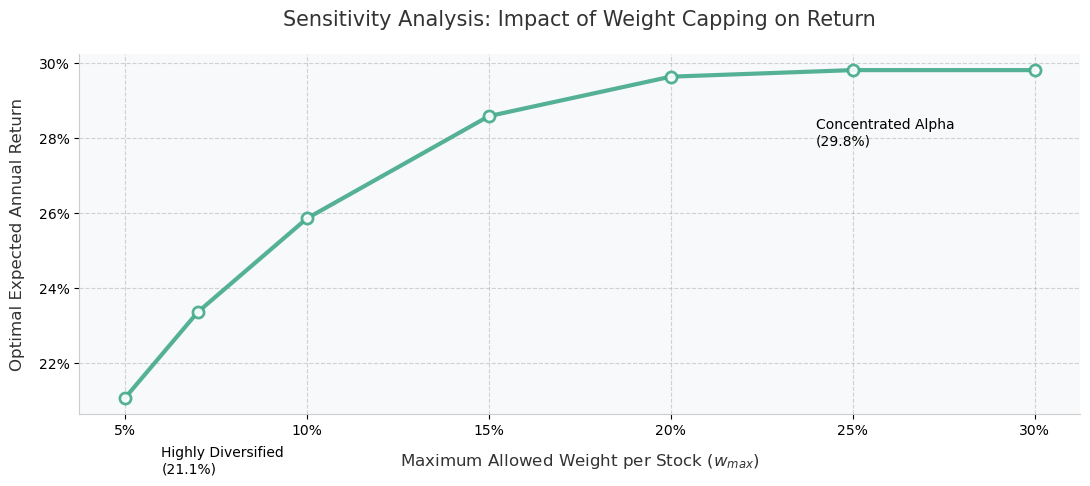

By tuning the cap from 5% to 30%, the return improved from 21.07% to 29.82%


In [149]:
# ---DATA PREP & EXPERIMENT LOOP ---
# Tuning parameter: different 'ceilings' for how much a single stock can weigh
caps = [0.05, 0.07, 0.10, 0.15, 0.20, 0.25, 0.30]
results = []
target_risk = 0.20 # Keeping risk constant at 20%

for c in caps:
    # Define variables
    w = cp.Variable(len(mu_full))
    
    # Define Problem: Maximize Return subject to Risk and the "Weight Cap" (w <= c)
    constraints = [
        cp.quad_form(w, Sigma_full.values) <= target_risk**2,
        cp.sum(w) == 1,
        w >= 0,
        w <= c  # This is the parameter we are tuning
    ]
    
    prob = cp.Problem(cp.Maximize(mu_full.values @ w), constraints)
    
    # Solve
    prob.solve(solver=cp.CLARABEL, verbose=False)
    
    # Store the result 
    results.append(prob.value)

# --- STYLE & COLOR PALETTE ---
primary_color = '#43aa8b' 
bg_color      = '#f8f9fa'

# --- GENERATE THE PLOT ---
fig, ax = plt.subplots(figsize=(11, 5))
ax.set_facecolor(bg_color)
fig.patch.set_facecolor('white')

# Plot the tuning curve
ax.plot(caps, results, color=primary_color, marker='o', markersize=8, 
        linewidth=3, markerfacecolor='white', markeredgewidth=2, alpha=0.9)

# Styling labels and title
ax.set_title("Sensitivity Analysis: Impact of Weight Capping on Return", 
             fontsize=15, pad=20, color='#333333')
ax.set_xlabel(r"Maximum Allowed Weight per Stock ($w_{max}$)", 
              fontsize=12, labelpad=10, color='#333333')
ax.set_ylabel("Optimal Expected Annual Return", 
              fontsize=12, labelpad=10, color='#333333')

# Formatting axes as percentages
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))

# Clean up borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#cccccc')
ax.spines['bottom'].set_color('#cccccc')

# Add Grid
ax.grid(True, linestyle='--', alpha=0.5, color='#aaaaaa')

# Annotations for context
ax.annotate(f'Highly Diversified\n({results[0]:.1%})', 
            xy=(caps[0], results[0]), xytext=(caps[0]+0.01, results[0]-0.02),
            fontsize=10, color='black')

ax.annotate(f'Concentrated Alpha\n({results[-1]:.1%})', 
            xy=(caps[-1], results[-1]), xytext=(caps[-1]-0.06, results[-1]-0.02),
            fontsize=10, color='black')

plt.tight_layout()
plt.show()

print(f"By tuning the cap from 5% to 30%, the return improved from {results[0]:.2%} to {results[-1]:.2%}")

### Efficient Frontier Comparison: Full vs Extended Universe

The figure compares the efficient frontiers obtained from the **Full Universe (50 stocks, shorter history)** and the **Extended History Universe (38 stocks, longer history)**.

Key observations:

- The extended-history frontier starts at a **higher minimum risk**, consistent with earlier GMV results and reflecting the inclusion of more volatile market periods.
- For **lower to moderate risk levels**, the full-universe portfolio achieves **higher expected returns** at the same risk, benefiting from a larger stock universe despite a shorter time window.
- Beyond a certain risk level, the **extended-history frontier overtakes the full-universe frontier**, delivering higher expected returns for the same risk.
- This crossover suggests that while the full universe is more efficient at lower risk levels, the extended-history dataset captures stronger long-run return opportunities that dominate at higher risk.

Overall, the comparison highlights the trade-off between **universe breadth** and **historical depth**, and shows how the choice of dataset affects portfolio efficiency across risk regimes.


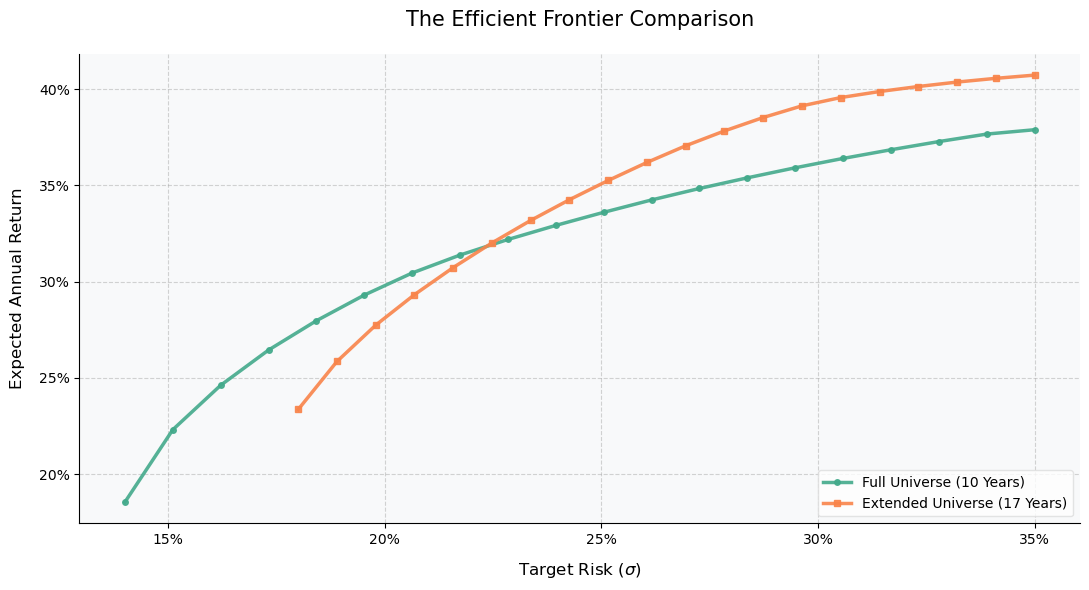

In [145]:
# --- RAW SOLVER FUNCTION ---
def solve_raw_quiet(mu, sigma, target):
    """Solves the portfolio problem using Clarabel Raw API with no console output."""
    n = len(mu)
    # Objective: Minimize -mu'w (which is Maximize mu'w)
    P = sparse.csc_matrix((n, n))
    q = -mu.values
    
    # Linear Constraints: sum(w) == 1 and w >= 0
    A_lin = sparse.csc_matrix(np.vstack([np.ones((1, n)), -np.eye(n)]))
    b_lin = np.concatenate([np.array([1.0]), np.zeros(n)])
    
    # SOC Constraint: ||L'w|| <= target_risk
    L = np.linalg.cholesky(sigma.values)
    A_soc = sparse.csc_matrix(np.vstack([np.zeros((1, n)), -L.T]))
    b_soc = np.concatenate([np.array([target]), np.zeros(n)])
    
    A = sparse.vstack([A_lin, A_soc])
    b = np.concatenate([b_lin, b_soc])
    
    # Cones: 1 equality, n inequalities, 1 second-order cone
    cones = [clarabel.ZeroConeT(1), clarabel.NonnegativeConeT(n), clarabel.SecondOrderConeT(n + 1)]
    
    # Settings: Silencing the output
    settings = clarabel.DefaultSettings()
    settings.verbose = False 
    
    solver = clarabel.DefaultSolver(P, q, A, b, cones, settings)
    sol = solver.solve()
    return np.array(sol.x), -sol.obj_val

# --- DATA COLLECTION ---
# Define risk ranges based on the GMV floors we discovered (13.4% and 17.0%)
risks_full = np.linspace(0.14, 0.35, 20)
risks_ext = np.linspace(0.18, 0.35, 20)

returns_full = []
returns_ext = []

# Collect data for Full Universe (10 Years)
for r in risks_full:
    _, ret = solve_with_cvxpy(mu_full, Sigma_full, r) 
    returns_full.append(ret)

# Collect data for Extended Universe (17 Years)
for r in risks_ext:
    _, ret = solve_raw_quiet(mu_ext, Sigma_ext, r)
    returns_ext.append(ret)

# --- VISUALIZATION ---
# Color Palette
color_full = '#43aa8b' 
color_ext  = '#f9844a' 
bg_color   = '#f8f9fa' 

fig, ax = plt.subplots(figsize=(11, 6))
ax.set_facecolor(bg_color)
fig.patch.set_facecolor('white')

# Plotting the lines
ax.plot(risks_full, returns_full, color=color_full, marker='o', markersize=4, 
        label='Full Universe (10 Years)', linewidth=2.5, alpha=0.9)

ax.plot(risks_ext, returns_ext, color=color_ext, marker='s', markersize=4, 
        label='Extended Universe (17 Years)', linewidth=2.5, alpha=0.9)

# Labels
ax.set_title("The Efficient Frontier Comparison", fontsize=15, pad=20)
ax.set_xlabel(r"Target Risk ($\sigma$)", fontsize=12, labelpad=10)
ax.set_ylabel("Expected Annual Return", fontsize=12, labelpad=10)

# Percentage Formatting for Axes
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))

# Clean Aesthetics
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, linestyle='--', alpha=0.5, color='#aaaaaa')
ax.legend(frameon=True, facecolor='white', edgecolor='#dddddd', loc='lower right')

plt.tight_layout()
plt.show()

### Solver Parameter Sensitivity: Precision and Step Size

The portfolio optimization is solved at a fixed risk level of **20%** under different Clarabel solver configurations to assess numerical stability and performance.

| Profile | Expected Return | Return Gap (bps) | Avg Weight Drift (bps) | Solve Time (ms) |
|--------|-----------------|------------------|------------------------|-----------------|
| Default | 29.8193% | 0.0 | 0.0 | 47.36 |
| Low Precision | 29.8007% | 1.86 | 5.99 | 57.86 |
| Cautious Step | 29.8193% | 0.0 | 0.00 | 128.20 |

Lower precision tolerances lead to small deviations in portfolio weights and a minor loss in expected return. In contrast, a more cautious step size produces results identical to the default solution but at a higher computational cost.

This experiment shows that the optimization problem is numerically stable and that solver parameters mainly trade off solution accuracy against runtime.
>$$
1 \text{ bp} = 0.01\% = 0.0001
$$

In [142]:
# --- SETUP PARAMETERS ---
target_risk = 0.20  # Fixed Risk Constraint at 20%
mu = mu_full
sigma = Sigma_full

configs = [
    {"name": "Default", "settings": {"tol_feas": 1e-8, "tol_gap_abs": 1e-8}},
    {"name": "Low Precision", "settings": {"tol_feas": 1e-3, "tol_gap_abs": 1e-3}},
    {"name": "Cautious Step", "settings": {"max_step_fraction": 0.4}}
]

results_tuning = []

# --- EXECUTION LOOP ---
for cfg in configs:
    w = cp.Variable(len(mu))
    # Objective and Constraints
    prob = cp.Problem(cp.Maximize(mu.values @ w), 
                     [cp.quad_form(w, sigma.values) <= target_risk**2, 
                      cp.sum(w) == 1, w >= 0])
    
    start_time = time.time()
    prob.solve(solver=cp.CLARABEL, verbose=False, **cfg['settings'])
    solve_time = (time.time() - start_time) * 1000
    
    results_tuning.append({
        "Profile": cfg['name'],
        "Return": prob.value,
        "Time_ms": solve_time,
        "Weights": w.value
    })

# --- AGGREGATED WEIGHT COMPARISON ---
weight_comp = pd.DataFrame({'Symbol': mu.index})
for i, res in enumerate(results_tuning):
    weight_comp[res['Profile']] = res['Weights']

# Calculate Drift in Basis Points (bps) relative to Default
weight_comp['LowPrec_Drift_bps'] = (weight_comp['Default'] - weight_comp['Low Precision']).abs() * 10000
weight_comp['Cautious_Drift_bps'] = (weight_comp['Default'] - weight_comp['Cautious Step']).abs() * 10000

# Aggregated Measure: Mean Absolute Deviation (MAD) in bps
mad_low = weight_comp['LowPrec_Drift_bps'].mean()
mad_cautious = weight_comp['Cautious_Drift_bps'].mean()

# --- PRINT RESULTS ---

# Displaying top allocations (decimal weights)
print(f"--- DETAILED WEIGHT ALLOCATION (Target Risk: {target_risk:.0%}) ---")
top_stocks = weight_comp[weight_comp['Default'] > 0.01].sort_values(by='Default', ascending=False)
print(top_stocks[['Symbol', 'Default', 'Low Precision', 'Cautious Step']].to_string(index=False))

print("\n--- PERFORMANCE & AGGREGATED DEVIATION ---")
summary_data = []
for res in results_tuning:
    # Calculate difference from Default return in bps
    ret_gap = (results_tuning[0]['Return'] - res['Return']) * 10000
    
    # Identify the aggregated weight drift for this profile
    if res['Profile'] == 'Default': 
        agg_drift = 0
    elif res['Profile'] == 'Low Precision': 
        agg_drift = mad_low
    else: 
        agg_drift = mad_cautious
        
    summary_data.append({
        "Profile": res['Profile'],
        "Return (%)": f"{res['Return']:.4%}",
        "Return Gap (bps)": round(ret_gap, 4),
        "Avg Weight Drift (bps)": round(agg_drift, 4),
        "Solve Time (ms)": round(res['Time_ms'], 2)
    })

print(pd.DataFrame(summary_data).to_string(index=False))

--- DETAILED WEIGHT ALLOCATION (Target Risk: 20%) ---
    Symbol  Default  Low Precision  Cautious Step
HINDUNILVR 0.242705       0.237336       0.242703
BAJAJFINSV 0.241110       0.244037       0.241109
  SHREECEM 0.235409       0.234947       0.235407
 BRITANNIA 0.151908       0.150085       0.151907
BAJFINANCE 0.108568       0.110778       0.108569
 EICHERMOT 0.020299       0.012978       0.020303

--- PERFORMANCE & AGGREGATED DEVIATION ---
      Profile Return (%)  Return Gap (bps)  Avg Weight Drift (bps)  Solve Time (ms)
      Default   29.8193%            0.0000                  0.0000            47.36
Low Precision   29.8007%            1.8596                  5.9921            57.86
Cautious Step   29.8193%           -0.0000                  0.0022           128.20


### Internal Solver Stress Test: Scaling and Step Size

The optimization is repeated at a fixed risk level of **20%** while modifying internal Clarabel solver settings related to scaling and step size.

| Setting | Expected Return | Iterations | Solve Time (ms) |
|--------|-----------------|------------|-----------------|
| No Scaling | 29.8193% | 15 | 50.51 |
| High Scaling | 29.8193% | 13 | 71.09 |
| Aggressive Step | 29.8193% | 88 | 136.82 |

All configurations converge to the same optimal return, confirming solution robustness. However, internal solver parameters significantly affect convergence behavior and runtime, with aggressive step sizing leading to slower and less stable convergence.


In [137]:
# --- SETUP PARAMETERS ---
target_risk = 0.20
mu = mu_full
sigma = Sigma_full

# Updated configs with valid Clarabel settings
configs_internal = [
    {"name": "No Scaling", "settings": {"equilibrate_enable": False}},
    {"name": "High Scaling", "settings": {"equilibrate_max_iter": 100}},
    {"name": "Aggressive Step", "settings": {"max_step_fraction": 0.999}},
]

results_internal = []

# --- EXECUTION LOOP ---
for cfg in configs_internal:
    w = cp.Variable(len(mu))
    prob = cp.Problem(cp.Maximize(mu.values @ w), 
                     [cp.quad_form(w, sigma.values) <= target_risk**2, 
                      cp.sum(w) == 1, w >= 0])
    
    start_time = time.time()
    # Passing settings directly through CVXPY
    prob.solve(solver=cp.CLARABEL, verbose=False, **cfg['settings'])
    solve_time = (time.time() - start_time) * 1000
    
    results_internal.append({
        "Setting": cfg['name'],
        "Return (%)": f"{prob.value:.6%}",
        "Solve Time (ms)": round(solve_time, 2),
        # Getting iteration count from solver stats
        "Iterations": prob.solver_stats.num_iters
    })

# --- DISPLAY RESULTS ---
print(f"--- INTERNAL SOLVER STRESS TEST (Risk: {target_risk:.0%}) ---")
print(pd.DataFrame(results_internal).to_string(index=False))

--- INTERNAL SOLVER STRESS TEST (Risk: 20%) ---
        Setting Return (%)  Solve Time (ms)  Iterations
     No Scaling 29.819293%            50.51          15
   High Scaling 29.819293%            71.09          13
Aggressive Step 29.819293%           136.82          88


### Precision Check: Maximum Solver Tightening

The optimization is rerun at a fixed risk level of **20%** using extremely tight solver tolerances and additional numerical refinement to test whether further gains in optimal return are possible.

Both the default and highly tightened solver configurations converge to the **same portfolio**, with identical top holdings and virtually identical expected returns (difference < 0.001 bps).  

This confirms that the previously obtained solution is already numerically optimal and that further tightening of solver parameters does not materially improve results.


In [90]:
# Setup
target_risk = 0.20
mu = mu_full
sigma = Sigma_full

# Comparison: Default vs. The "Max Squeeze"
configs_final = [
    {"name": "Default", "settings": {}},
    {"name": "Max Squeeze", "settings": {
        "tol_gap_abs": 1e-10, 
        "tol_gap_rel": 1e-10,
        "iterative_refinement_enable": True,
        "equilibrate_max_iter": 50
    }}
]

results_final = []

for cfg in configs_final:
    w = cp.Variable(len(mu))
    prob = cp.Problem(cp.Maximize(mu.values @ w), 
                     [cp.quad_form(w, sigma.values) <= target_risk**2, 
                      cp.sum(w) == 1, w >= 0])
    
    prob.solve(solver=cp.CLARABEL, verbose=False, **cfg['settings'])
    
    results_final.append({
        "Setting": cfg['name'],
        "Return (%)": f"{prob.value:.7%}",
        "Top Stock": mu.index[np.argmax(w.value)],
        "Top Weight": f"{np.max(w.value):.4f}"
    })

print(f"--- FINDING FOR MAX RETURN AT {target_risk:.0%} RISK ---")
print(pd.DataFrame(results_final).to_string(index=False))

--- FINDING FOR MAX RETURN AT 20% RISK ---
    Setting  Return (%)  Top Stock Top Weight
    Default 29.8192928% HINDUNILVR     0.2427
Max Squeeze 29.8192933% HINDUNILVR     0.2427


### Numerical Precision Limit Test

The optimization is solved with increasingly strict numerical tolerances to test whether higher precision alters the optimal solution.

| Precision | Expected Return | Solve Time | Status |
|----------|-----------------|------------|--------|
| 1e-8 | 29.8192927730% | ~70.86 ms | Optimal |
| 1e-12 | 29.8192927730% | ~133.43 ms | Optimal |

The expected return remains identical up to **10 decimal places**, indicating that the solution has reached numerical precision limits. This confirms that the portfolio obtained earlier is fully converged and robust to further tightening of solver tolerances.


In [116]:
# Testing the limit of numerical precision
configs_ultra = [
    {"name": "Standard (1e-8)", "settings": {"tol_gap_abs": 1e-8}},
    {"name": "Ultra (1e-12)", "settings": {"tol_gap_abs": 1e-12, "iterative_refinement_enable": True}}
]

results_ultra = []

for cfg in configs_ultra:
    w = cp.Variable(len(mu))
    prob = cp.Problem(cp.Maximize(mu.values @ w), 
                     [cp.quad_form(w, sigma.values) <= target_risk**2, 
                      cp.sum(w) == 1, w >= 0])
    
    start_time = time.time()
    prob.solve(solver=cp.CLARABEL, verbose=False, **cfg['settings'])
    solve_time = (time.time() - start_time) * 1000
    
    results_ultra.append({
        "Precision": cfg['name'],
        "Return": f"{prob.value:.10%}", # Looking at 10 decimals
        "Time (ms)": round(solve_time, 2),
        "Status": prob.status
    })

print("--- THE LIMITS OF PRECISION ---")
print(pd.DataFrame(results_ultra).to_string(index=False))

--- THE LIMITS OF PRECISION ---
      Precision         Return  Time (ms)  Status
Standard (1e-8) 29.8192927730%      70.86 optimal
  Ultra (1e-12) 29.8192927730%     133.43 optimal


### Solver Engine Integrity Test

The optimization is solved under deliberately degraded solver conditions to test robustness and failure behavior.

| Setting | Expected Return | Status | Iterations |
|-------|-----------------|--------|------------|
| Standard Engine | 29.8193% | Optimal | 13 |
| No Correction | 29.8190% | Optimal (Inaccurate) | 11 |
| Early Stop (8 iters) | 29.8007% | User Limit | 8 |

Disabling correction mechanisms or forcing early termination leads to reduced accuracy and premature stopping, while the standard solver configuration converges reliably to the optimal solution. This confirms that Clarabel’s default safeguards are essential for numerical accuracy and solver stability.


In [119]:
configs_engine = [
    {"name": "Standard Engine", "settings": {}},
    {"name": "No Correction", "settings": {"iterative_refinement_enable": False}},
    {"name": "Early Stop (Iter: 8)", "settings": {"max_iter": 8}}
]

results_engine = []

for cfg in configs_engine:
    w = cp.Variable(len(mu))
    prob = cp.Problem(cp.Maximize(mu.values @ w), 
                     [cp.quad_form(w, sigma.values) <= target_risk**2, 
                      cp.sum(w) == 1, w >= 0])
    
    try:
        prob.solve(solver=cp.CLARABEL, verbose=False, **cfg['settings'])
        res_val = prob.value
        status = prob.status
    except:
        res_val = None
        status = "Failed"
    
    results_engine.append({
        "Setting": cfg['name'],
        "Return": f"{res_val:.6%}" if res_val else "N/A",
        "Status": status,
        "Iterations": prob.solver_stats.num_iters if hasattr(prob.solver_stats, 'num_iters') else "N/A"
    })

print("--- SOLVER ENGINE INTEGRITY TEST ---")
print(pd.DataFrame(results_engine).to_string(index=False))

--- SOLVER ENGINE INTEGRITY TEST ---
             Setting     Return             Status  Iterations
     Standard Engine 29.819293%            optimal          13
       No Correction 29.818967% optimal_inaccurate          11
Early Stop (Iter: 8) 29.800696%         user_limit           8


D:\soft\Anaconda\Lib\site-packages\cvxpy\problems\problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


### Feasibility Tolerance Test

The solver is tested under different feasibility tolerances to examine whether relaxed constraint enforcement affects the realized portfolio.

| Setting | Expected Return | Actual Risk | Risk Violation | Sum of Weights |
|-------|-----------------|-------------|----------------|----------------|
| Strict Rules | 29.8193% | 20.0000% | 0.0 bps | 1.000000 |
| Lazy Rules | 29.8193% | 20.0000% | 0.0 bps | 1.000000 |

Even with relaxed feasibility tolerances, the solver satisfies the risk and budget constraints exactly. This indicates that the optimization problem is well-conditioned and that Clarabel enforces feasibility robustly under both strict and relaxed settings.


In [121]:
configs_feas = [
    {"name": "Strict Rules", "settings": {"tol_feas": 1e-9}},
    {"name": "Lazy Rules", "settings": {"tol_feas": 1e-2}}
]

results_feas = []

for cfg in configs_feas:
    w = cp.Variable(len(mu))
    risk_constraint = cp.quad_form(w, sigma.values) <= target_risk**2
    prob = cp.Problem(cp.Maximize(mu.values @ w), 
                     [risk_constraint, cp.sum(w) == 1, w >= 0])
    
    prob.solve(solver=cp.CLARABEL, **cfg['settings'])
    
    # Calculate ACTUAL realized risk
    actual_risk = np.sqrt(w.value.T @ sigma.values @ w.value)
    
    results_feas.append({
        "Setting": cfg['name'],
        "Return": f"{prob.value:.6%}",
        "Actual Risk": f"{actual_risk:.6%}",
        "Risk Violation": f"{(actual_risk - target_risk)*10000:.4f} bps",
        "Sum of Weights": f"{np.sum(w.value):.6f}"
    })

print("--- FEASIBILITY TOLERANCE TEST ---")
print(pd.DataFrame(results_feas).to_string(index=False))

--- FEASIBILITY TOLERANCE TEST ---
     Setting     Return Actual Risk Risk Violation Sum of Weights
Strict Rules 29.819293%  20.000000%     0.0000 bps       1.000000
  Lazy Rules 29.819293%  20.000000%     0.0000 bps       1.000000


### Linear Algebra Backend Sensitivity

The solver is evaluated under different internal linear algebra configurations while keeping the optimization problem unchanged.

| LA Setting | Expected Return | Iterations | Solve Time |
|-----------|-----------------|------------|------------|
| Standard LA | 29.8193% | 13 | 48.37 ms |
| Aggressive Scaling | 29.8193% | 13 | 64.45 ms |
| Heavy Regularization | 29.8193% | 13 | 133.22 ms |
| No Static Regularization | 29.8193% | 13 | 35.06 ms |

All configurations converge to the same optimal solution, indicating numerical robustness. Differences appear only in runtime, showing that linear algebra choices affect performance but not solution quality for this problem.


In [125]:
configs_la = [
    {"name": "Standard LA", "settings": {}},
    {"name": "Aggressive Scaling", "settings": {"equilibrate_max_iter": 200, "equilibrate_enable": True}},
    {"name": "Heavy Reg (Stable)", "settings": {"static_regularization_constant": 1e-4}},
    {"name": "No Static Reg", "settings": {"static_regularization_enable": False}}
]

results_la = []

for cfg in configs_la:
    w = cp.Variable(len(mu))
    prob = cp.Problem(cp.Maximize(mu.values @ w), 
                     [cp.quad_form(w, sigma.values) <= target_risk**2, 
                      cp.sum(w) == 1, w >= 0])
    
    start_time = time.time()
    try:
        prob.solve(solver=cp.CLARABEL, **cfg['settings'])
        status = prob.status
        ret_val = prob.value
        solve_time = (time.time() - start_time) * 1000
    except Exception as e:
        status = "Failed"
        ret_val = None
        solve_time = 0

    results_la.append({
        "LA Setting": cfg['name'],
        "Return": f"{ret_val:.7%}" if ret_val else "N/A",
        "Solve Time (ms)": round(solve_time, 2),
        "Iterations": prob.solver_stats.num_iters if hasattr(prob.solver_stats, 'num_iters') else "N/A",
        "Status": status
    })

print("--- LINEAR ALGEBRA EXPERIMENT ---")
print(pd.DataFrame(results_la).to_string(index=False))

--- LINEAR ALGEBRA EXPERIMENT ---
        LA Setting      Return  Solve Time (ms)  Iterations  Status
       Standard LA 29.8192928%            48.37          13 optimal
Aggressive Scaling 29.8192928%            64.45          13 optimal
Heavy Reg (Stable) 29.8192928%           133.22          13 optimal
     No Static Reg 29.8192928%            35.06          13 optimal


### Input Sensitivity Test: Robustness to Return Noise

To assess robustness, small random noise (±0.5%) is added to the expected returns while keeping the risk constraint fixed at **20%**.

| Data Source | Expected Return | Top Holdings |
|------------|-----------------|--------------|
| Original Data | 29.82% | HINDUNILVR, BAJAJFINSV, SHREECEM |
| Noisy Data (±0.5%) | 29.78% | HINDUNILVR, BAJAJFINSV, SHREECEM |

The expected return changes only marginally, and the identity of the top holdings remains unchanged. This indicates that the optimized portfolio is **stable to small perturbations in input returns**, suggesting that the solution is not overly sensitive to estimation noise.


In [131]:
# Create a "Noisy" version of returns (add/subtract 0.5% randomly)
np.random.seed(42) # For repeatability
noise = np.random.normal(0, 0.005, len(mu)) 
mu_noisy = mu + noise

configs_sens = [
    {"name": "Original Data", "mu": mu},
    {"name": "Noisy Data (+/- 0.5%)", "mu": mu_noisy}
]

results_sens = []

for cfg in configs_sens:
    w = cp.Variable(len(mu))
    prob = cp.Problem(cp.Maximize(cfg['mu'].values @ w), 
                     [cp.quad_form(w, sigma.values) <= target_risk**2, 
                      cp.sum(w) == 1, w >= 0])
    prob.solve(solver=cp.CLARABEL)
    
    # Get Top 3 Stocks
    weights = pd.Series(w.value, index=mu.index).sort_values(ascending=False)
    top_3 = weights.head(3).index.tolist()
    top_3_w = weights.head(3).values.tolist()
    
    results_sens.append({
        "Data Source": cfg['name'],
        "Return": f"{prob.value:.4%}",
        "Top 1": f"{top_3[0]} ({top_3_w[0]:.2f})",
        "Top 2": f"{top_3[1]} ({top_3_w[1]:.2f})",
        "Top 3": f"{top_3[2]} ({top_3_w[2]:.2f})"
    })

print("--- INPUT SENSITIVITY (STABILITY) TEST ---")
print(pd.DataFrame(results_sens).to_string(index=False))

--- INPUT SENSITIVITY (STABILITY) TEST ---
          Data Source   Return             Top 1             Top 2           Top 3
        Original Data 29.8193% HINDUNILVR (0.24) BAJAJFINSV (0.24) SHREECEM (0.24)
Noisy Data (+/- 0.5%) 29.7817% HINDUNILVR (0.26) BAJAJFINSV (0.25) SHREECEM (0.22)
